In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [3]:
epoch_key = ("Jaq", 3, 2)

In [ ]:
from src.load_data import load_data

data = load_data(epoch_key)

In [ ]:
data["spikes"].shape

In [ ]:
from dask.distributed import Client

client = Client(n_workers=16, threads_per_worker=4)
client

In [ ]:
from replay_trajectory_classification import SortedSpikesClassifier

from src.parameters import (discrete_state_transition,
                            EDGE_ORDER, EDGE_SPACING, ANIMALS)

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

from src.load_data import make_track_graph
import numpy as np


track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)
is_running = np.abs(data["position_info"].tailBase_vel) > 4
is_outbound = data["position_info"].task == "Outbound"

classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': [['random_walk', 'uniform'],
                                    ['uniform',     'uniform']],
    'knot_spacing': 5,
    'spike_model_penalty': 0.5
}

cv = KFold()
cv_classifier_sorted_spikes_results = []

for fold_ind, (train, test) in tqdm(enumerate(cv.split(data["position_info"].index))):
    
    #train = train[is_outbound[train].values]
    
    cv_classifier = SortedSpikesClassifier(**classifier_parameters)

    cv_classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        spikes=data["spikes"].iloc[train],
        is_training=is_running.iloc[train],
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )
    cv_classifier.discrete_state_transition_ = discrete_state_transition
    logging.info('Predicting posterior...')
    cv_classifier_sorted_spikes_results.append(
        cv_classifier.predict(
            data["spikes"].iloc[test],
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
        )
    )
    
# concatenate cv classifier results 
cv_classifier_sorted_spikes_results = xr.concat(
    cv_classifier_clusterless_results, dim="time"
)
cv_classifier_sorted_spikes_results

In [ ]:
# save the results as .nc format. ncread matlab can read these
cv_classifier_clusterless_results.to_netcdf(
   f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier_sortedspikes_vel_4_nose_alltime_results.nc"
)

In [10]:
cv_classifier.save_model(f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier_sortedspikes")

In [17]:
def get_place_field_max(classifier):
    try:
        max_ind = classifier.place_fields_.argmax('position')
        return np.asarray(
            classifier.place_fields_.position[max_ind].values.tolist())
    except AttributeError:
        return np.asarray(
            [classifier.place_bin_centers_[gpi.argmax()]
             for gpi in classifier.ground_process_intensities_])

In [22]:
cv_classifier.place_fields_

place_field_max = get_place_field_max(cv_classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()
linear_position_order

array([112,  16,  37, 114,  13,  84,  44,  70, 111,  47,  69,  68, 107,
        51,  52,  25,  26,   8, 110, 105,   5,   2,  91,  24, 103,  74,
        27,  32,  58,  29,  65,  57,  54,   7,  39,  67,  21,  99,  85,
        42,  83,   3, 123,  63,  41,  30, 121,  82,   9, 118,  71,  22,
        20,  11,  62,   4, 120, 108,   0,  40,  23,  19,  45,  49,  34,
       115,  86,  87,  93,  79,  48,  94, 113,  35,  66, 101,  36,  80,
        17,  14,  12,  90,  50,  61, 125,  60,  96,  95,  55, 100,  78,
       106,  77,   1,  97, 102,  92, 124,  72,  33,  89, 122,   6,  10,
       119,  64, 117, 116,  53,  46,  15,  73,  18, 109,  43,  75,  76,
        28, 104,  31,  81,  38,  88,  98,  56,  59])

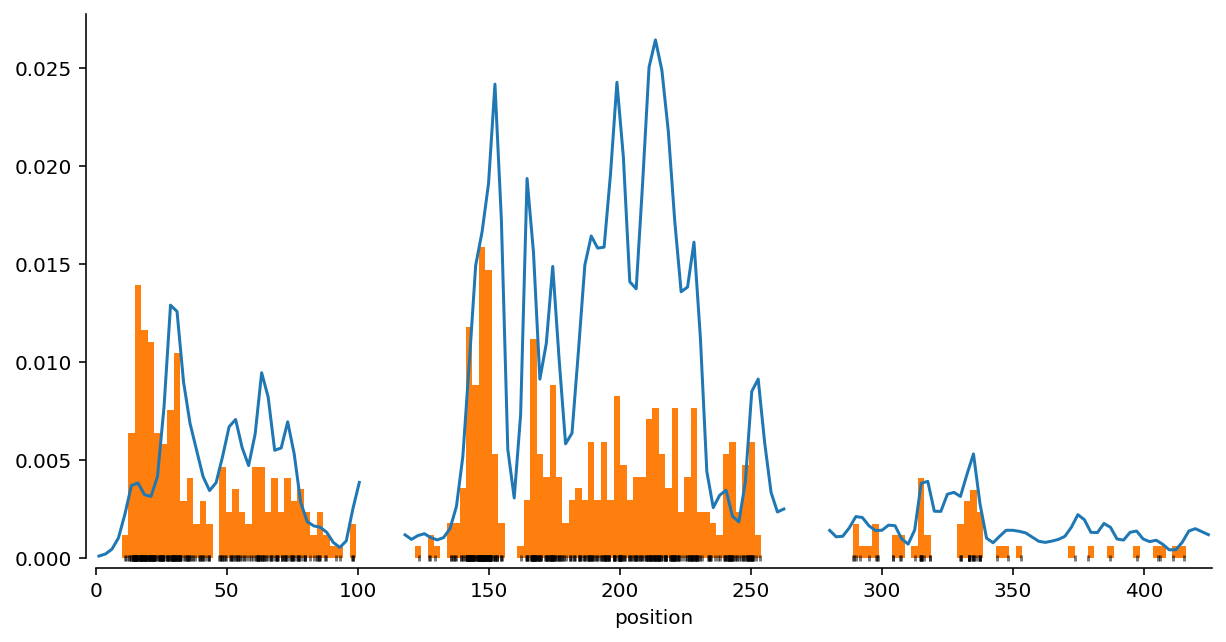

In [142]:
neuron_ind = 9

is_train = is_running.iloc[train]
position = data["position_info"].iloc[train].linear_position.values[is_train]
spikes = data["spikes"].iloc[train, neuron_ind].values[is_train]
spike_position = position[np.nonzero(spikes)[0]]


plt.figure(figsize=(10, 5))
(cv_classifier.place_fields_).isel(neuron=neuron_ind).where(cv_classifier.is_track_interior_).plot(x="position")
plt.scatter(spike_position, np.zeros_like(spike_position), color="black", clip_on=False, zorder=100, s=10, marker="|", alpha=0.5)
plt.hist(spike_position, density=True, bins=cv_classifier.place_bin_edges_.squeeze());
plt.xlim((0, cv_classifier.place_bin_edges_.max()))
sns.despine(offset=5)

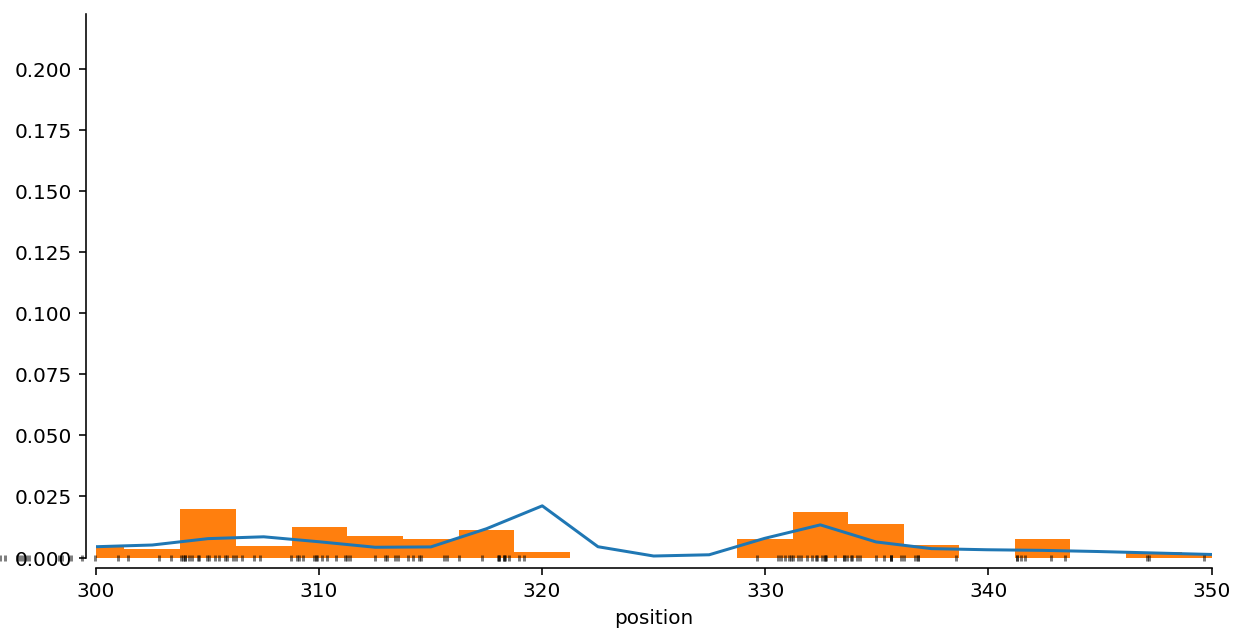

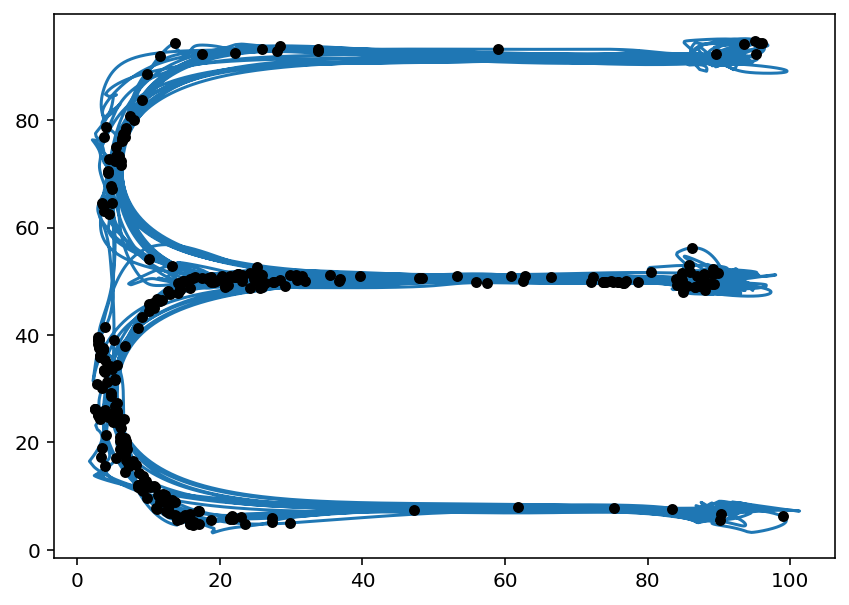

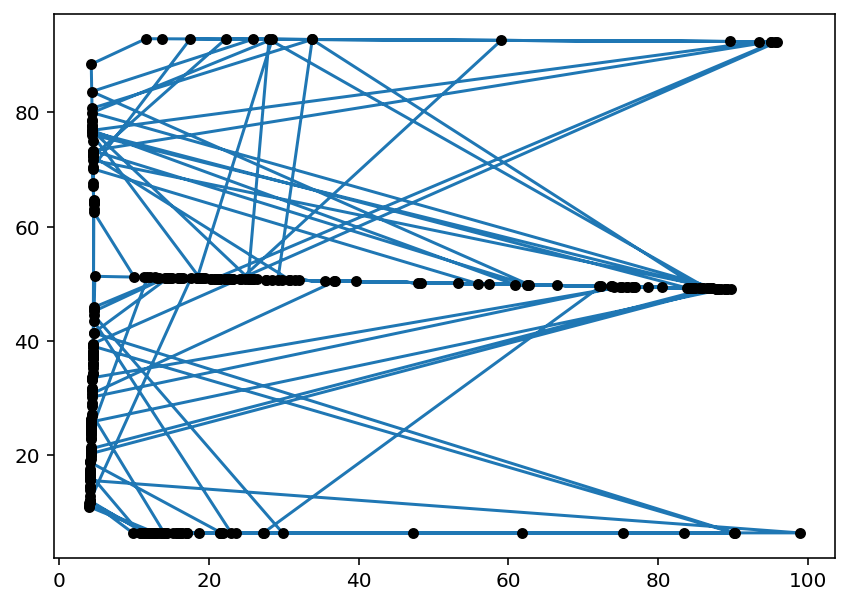

In [194]:
neuron_ind = 25

is_train = is_running.iloc[train]
position = data["position_info"].iloc[train].linear_position.values[is_train]
position_2D = data["position_info"].iloc[train].loc[:, ['tailBase_x', 'tailBase_y']].values[is_train]
projected_2D_position = data["position_info"].iloc[train].loc[:, ['projected_x_position', 'projected_y_position']].values[is_train]
spikes = data["spikes"].iloc[train, neuron_ind].values[is_train]
spike_position = position[np.nonzero(spikes)[0]]
spike_projected_position_2D = projected_2D_position[np.nonzero(spikes)[0]]



plt.figure(figsize=(10, 5))
(cv_classifier.place_fields_).isel(neuron=neuron_ind).where(cv_classifier.is_track_interior_).plot(x="position")
plt.scatter(spike_position, np.zeros_like(spike_position), color="black", clip_on=False, zorder=100, s=10, marker="|", alpha=0.5)
plt.hist(spike_position, density=True, bins=cv_classifier.place_bin_edges_.squeeze());
plt.xlim((0, cv_classifier.place_bin_edges_.max()))
sns.despine(offset=5)
plt.xlim((300, 350))

plt.figure(figsize=(7, 5))
plt.plot(position_2D[:, 0], position_2D[:, 1])
plt.scatter(spike_position_2D[:, 0], spike_position_2D[:, 1], zorder=100, color="black", s=20)

plt.figure(figsize=(7, 5))
plt.plot(spike_projected_position_2D[:, 0], spike_projected_position_2D[:, 1])
plt.scatter(spike_projected_position_2D[:, 0], spike_projected_position_2D[:, 1], zorder=100, color="black", s=20)


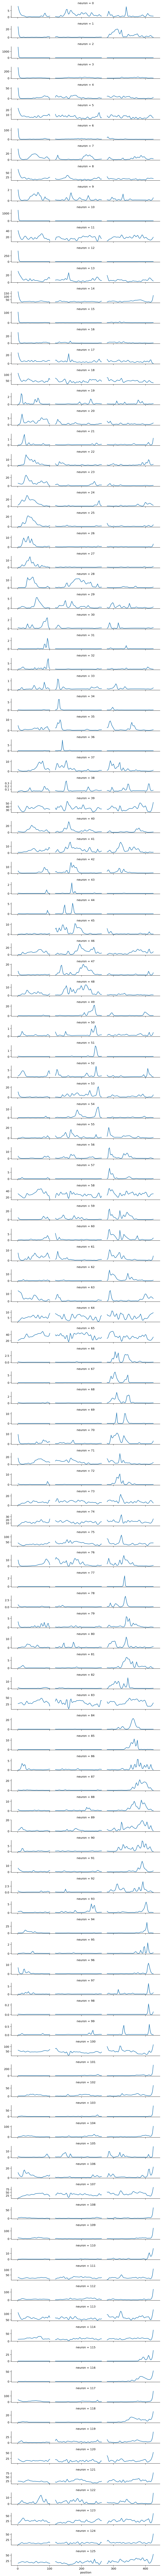

In [37]:
from src.parameters import SAMPLING_FREQUENCY
from src.analysis import get_place_field_max
import seaborn as sns

place_field_max = get_place_field_max(cv_classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()

(cv_classifier.place_fields_.where(cv_classifier.is_track_interior_[:, np.newaxis]).isel(neuron=linear_position_order) * SAMPLING_FREQUENCY).plot(
    x="position", col="neuron", col_wrap=1, add_legend=False, aspect=7, size=1, sharey=False);
sns.despine()

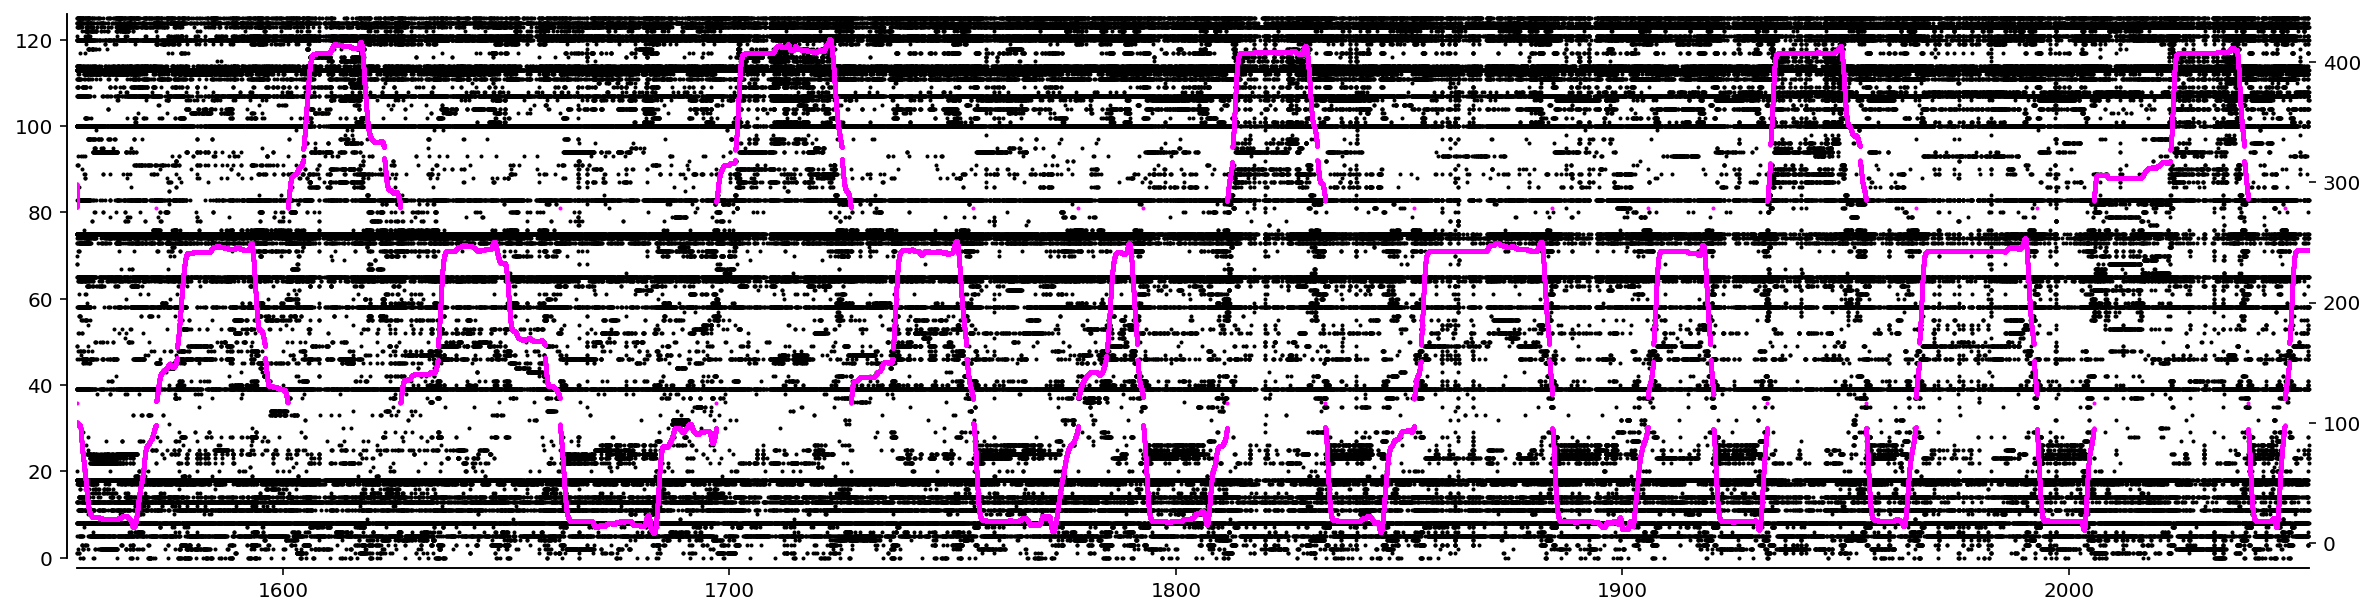

In [181]:
from src.analysis import get_place_field_max


time_slice = slice(0, 250_000)

place_field_max = get_place_field_max(cv_classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()

spikes = np.asarray(data["spikes"].iloc[time_slice, linear_position_order])
time = data["spikes"].iloc[time_slice].index / np.timedelta64(1, 's')

spike_time_ind, neuron_ind = np.nonzero(spikes)

fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(time[spike_time_ind], neuron_ind, s=1, color="black", clip_on=False)
twin_ax = ax.twinx()
twin_ax.scatter(time, data["position_info"].iloc[time_slice].linear_position, color="magenta", s=1)
ax.set_xlim((time.min(), time.max()))
ax.set_ylim((0, spikes.shape[1]))
sns.despine(offset=5)

In [ ]:
ax.twinx

In [60]:
is_accepted = np.asarray(data["neuron_info"].accepted.astype(bool))
data["spikes"].shape

(454860, 126)

In [56]:
data["neuron_info"].shape

(325, 19)

In [212]:
from loren_frank_data_processing import get_spikes_dataframe

neuron_info = data["neuron_info"].copy()
neuron_info = neuron_info.loc[neuron_info.accepted.astype(bool)]

s = [get_spikes_dataframe(neuron_key, ANIMALS) for neuron_key in neuron_info.index]

In [213]:
len(s)

140

In [222]:
s[7]

Series([], Name: Jaq_03_02_002_006, dtype: int64)

In [223]:
neuron_info.iloc[7]

bursting_parent                                                               0
dur_sec                                                                 906.694
firing_rate                                                              1.1746
isolation                                                              0.992949
noise_overlap                                                        0.00235018
num_events                                                                 1065
overlap_cluster                                                              22
peak_amp                                                                9.48139
peak_noise                                                              2.10345
peak_snr                                                                4.50754
t1_sec                                                                  1254.14
t2_sec                                                                  2160.83
label                                   

In [175]:
s[1].sum()

17029

In [202]:
np.nonzero(data["neuron_info"].accepted.values)[0]

array([  1,   8,   9,  11,  12,  14,  15,  18,  22,  23,  30,  31,  35,
        36,  48,  58,  59,  60,  64,  68,  71,  72,  74,  75,  76,  78,
        79,  80,  82,  83,  84,  85,  86,  87,  88,  90,  91,  92,  94,
        95,  96,  97,  98, 101, 102, 105, 106, 107, 108, 109, 110, 111,
       119, 121, 124, 126, 128, 132, 133, 134, 136, 142, 150, 151, 154,
       157, 159, 160, 161, 162, 163, 166, 168, 172, 174, 178, 179, 183,
       186, 193, 195, 198, 200, 201, 202, 213, 214, 215, 216, 217, 218,
       223, 226, 228, 229, 230, 239, 241, 244, 245, 246, 252, 254, 256,
       258, 261, 262, 264, 265, 266, 268, 269, 270, 274, 277, 278, 279,
       280, 281, 284, 287, 289, 290, 295, 297, 300, 301, 302, 303, 304,
       305, 307, 312, 313, 317, 318, 319, 320, 321, 322])

In [173]:
from loren_frank_data_processing.neurons import get_data_filename, loadmat
animals = ANIMALS
animal, day, epoch, tetrode_number, neuron_number = data["neuron_info"].iloc[0].name

neuron_file = loadmat(
    get_data_filename(animals[animal], day, 'spikes'))
neuron_file['spikes'][0, -1][0, epoch - 1][0, tetrode_number - 1][0, neuron_number - 1]

array([], shape=(0, 0), dtype=uint8)

In [204]:
data["neuron_info"].tags.iloc[0]

(b'',
 b'MCOS',
 b'string',
 array([[3707764736],
        [         2],
        [         1],
        [         1],
        [      5648],
        [         1]], dtype=uint32))

In [206]:
data["neuron_info"].columns

Index(['bursting_parent', 'dur_sec', 'firing_rate', 'isolation',
       'noise_overlap', 'num_events', 'overlap_cluster', 'peak_amp',
       'peak_noise', 'peak_snr', 't1_sec', 't2_sec', 'label',
       'firingrate_first2lastspike', 'firingrate_per_epoch', 'tags',
       'accepted', 'neuron_id', 'firing_rate_precise'],
      dtype='object')

bursting_parent     dur_sec  \
animal day epoch tetrode_number neuron_number                                
Jaq    3   2     1              2                            0  909.572300   
                                9                            0  869.927667   
                                10                           0  895.307367   
                                14                           0  908.715133   
                                19                           0  904.041400   
...                                                        ...         ...   
                 30             18                           0  908.190467   
                                19                           0  886.259400   
                                20                           0  892.630033   
                                21                           0  894.877267   
                                22                           0  859.969467   

                                               firing_rate  isolation  \
animal day epoch tetrode_number neuron_number                           
Jaq    3   2     1              2                18.721986   0.999706   
                                9                 0.329912   0.996477   
                                10                1.668701   0.996181   
                                14                1.652883   0.978848   
                                19                1.205697   0.997650   
...                                                    ...        ...   
                 30             18                5.324874   0.970917   
                                19                3.955952   0.997650   
                                20                0.821169   0.994418   
                                21                0.707360   0.970917   
                                22                0.280243   0.999483   

                                               noise_overlap  num_events  \
animal day epoch tetrode_number neuron_number                              
Jaq    3   2     1              2                   0.011163       17029   
                                9                   0.002516         287   
                                10                  0.001763        1494   
                                14                  0.001175        1502   
                                19                  0.002350        1090   
...                                                      ...         ...   
                 30             18                  0.008230        4836   
                                19                  0.000000        3506   
                                20                  0.001174         733   
                                21                  0.003231         633   
                                22                  0.003099         241   

                                               overlap_cluster   peak_amp  \
animal day epoch tetrode_number neuron_number                               
Jaq    3   2     1              2                            7   8.454528   
                                9                           11  18.705309   
                                10                           1   8.531854   
                                14                           5  20.365950   
                                19                           1   9.403018   
...                                                        ...        ...   
                 30             18                          21   7.868541   
                                19                          20  41.294250   
                                20                          18  18.513519   
                                21                          18   9.622410   
                                22                          18  16.118736   

                                               peak_noise  peak_snr  \
animal day epoch tet